In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/My Drive/Dataset

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Dataset


In [2]:
import numpy as np
import pandas as pd
import time
import nltk
# nltk.download('punkt') # one time execution
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [3]:
data = pd.read_excel('dataset.xlsx',nrows=1000)
data.head()

,Unnamed: 0,id,human_summary,publication,author,date,year,month,theme,content
0,0,17283,In successfully seeking a temporary halt in th...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,politics,WASHINGTON — Congressional Republicans have...
1,0,17284,Officers put her in worse danger some months l...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,crime,"After the bullet shells get counted, the blood..."
2,0,17285,The film striking appearance had been created ...,New York Times,Margalit Fox,2017-01-06,2017.0,1.0,entertainment,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,0,17286,The year was only days old when the news came ...,New York Times,William McDonald,2017-04-10,2017.0,4.0,entertainment,"Death may be the great equalizer, but it isn’t..."
4,0,17287,If North Korea conducts a test in coming month...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,politics,"SEOUL, South Korea — North Korea’s leader, ..."


In [4]:
print(data.columns)
data = data.rename(columns={'content':'articles'})

Index(['Unnamed: 0', 'id', 'human_summary', 'publication', 'author', 'date',
       'year', 'month', 'theme', 'content'],
      dtype='object')


In [5]:
data.head()


,Unnamed: 0,id,human_summary,publication,author,date,year,month,theme,articles
0,0,17283,In successfully seeking a temporary halt in th...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,politics,WASHINGTON — Congressional Republicans have...
1,0,17284,Officers put her in worse danger some months l...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,crime,"After the bullet shells get counted, the blood..."
2,0,17285,The film striking appearance had been created ...,New York Times,Margalit Fox,2017-01-06,2017.0,1.0,entertainment,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,0,17286,The year was only days old when the news came ...,New York Times,William McDonald,2017-04-10,2017.0,4.0,entertainment,"Death may be the great equalizer, but it isn’t..."
4,0,17287,If North Korea conducts a test in coming month...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,politics,"SEOUL, South Korea — North Korea’s leader, ..."


In [6]:
data = data.filter(['human_summary','articles','theme'])

In [7]:
print("Checking for empty data: ")
print(data.isnull().sum())
print('\n')

Checking for empty data: 
human_summary    0
articles         0
theme            0
dtype: int64




In [8]:
data.head()

,human_summary,articles,theme
0,In successfully seeking a temporary halt in th...,WASHINGTON — Congressional Republicans have...,politics
1,Officers put her in worse danger some months l...,"After the bullet shells get counted, the blood...",crime
2,The film striking appearance had been created ...,"When Walt Disney’s “Bambi” opened in 1942, cri...",entertainment
3,The year was only days old when the news came ...,"Death may be the great equalizer, but it isn’t...",entertainment
4,If North Korea conducts a test in coming month...,"SEOUL, South Korea — North Korea’s leader, ...",politics


In [9]:
contraction_expander = {
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", 
"could've": "could have", "couldn't": "could not","couldn't've": "could not have", "didn't": "did not", 
"doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
"haven't": "have not", "he'd": "he would", "he'd've": "he would have","he'll": "he will", "he's": "he is", 
"how'd": "how did", "how'll": "how will","how's": "how is","i'd": "i would","i'll": "i will","i'm": "i am",
"i've": "i have", "isn't": "is not","it'd": "it would","it'll": "it will","it's": "it is","let's": "let us",
"ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","must've": 
"must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not",
"sha'n't": "shall not","she'd": "she would", "she'll": "she will","she's": "she is","should've": "should have",
"shouldn't": "should not","that'd": "that would", "that's": "that is", "there'd": "there had","there's": "there is",
"they'd": "they would","they'll": "they will", "they're": "they are","they've": "they have","wasn't": "was not",
"we'd": "we would", "we'll": "we will","we're": "we are","we've": "we have","weren't": "were not",
"what'll": "what will","what're": "what are","what's": "what is", "what've": "what have","where'd": "where did",
"where's": "where is","who'll": "who will","who's": "who is", "won't": "will not","wouldn't": "would not",
"you'd": "you would","you'll": "you will","you're": "you are"
}

In [10]:
def cleaning(content):
    content = content.lower()
    #expand contractions
    expanded_form = []
    for i in content.split():
        if i in contraction_expander:
            expanded_form = expanded_form + [contraction_expander[i]]
        else:
            expanded_form = expanded_form + [i]
    content = ' '.join(expanded_form)

    content = re.sub(r"\([^()]*\)", "", content) #remove words in brackets
    content = content.replace("_____","")
    content = content.replace("■","")
    content = content.replace("•","")


    punctuation = '''!()-[]|{};:'"\,<>/?@#$%^&*_~—“””''' #punctuation
    for i in content:  
      if i in punctuation:  
        content = content.replace(i, "")  
    
    content = content.replace("’s","")
    content = content.replace("_______ •","")

    content = re.sub('\s+', ' ', content).strip()
    content = re.sub("https*\S+", " ", content)

    return content



clean_summary = []
for summary in data.human_summary:
    clean_summary.append(cleaning(summary))

clean_text = []
for text in data.articles:
    clean_text.append(cleaning(text))

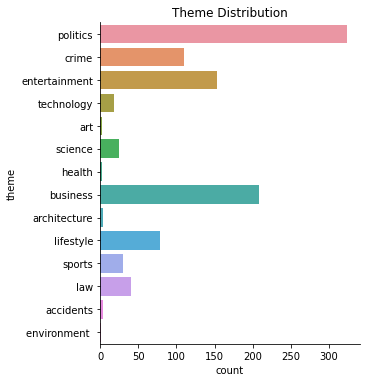

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

data['theme'].str.lower()
sns.catplot(y="theme", kind = "count",data = data)
plt.title('Theme Distribution');

In [12]:
data['clean_articles'] = clean_text
data['clean_summaries'] = clean_summary

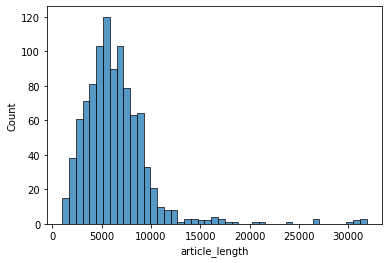

In [13]:
data['article_length'] = data['clean_articles'].astype(str).apply(len)
import seaborn as sns
sns.histplot(data, x = 'article_length', bins = 45)

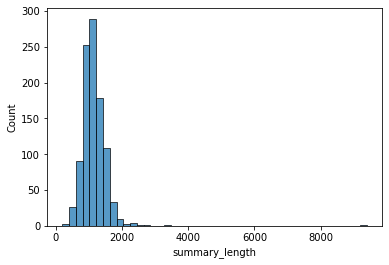

In [14]:
data['summary_length'] = data['clean_summaries'].astype(str).apply(len)
sns.histplot(data, x = 'summary_length', bins = 45)

In [15]:
article_length = pd.DataFrame(data.articles.apply(len).values, columns =['Articles'])
article_length['Summaries'] = data.human_summary.apply(len)
pd.DataFrame(article_length.mean().apply(lambda x: round(x,3)), columns = ['mean'])

,mean
Articles,6679.73
Summaries,1168.87


In [16]:
article_length_quant = article_length.quantile([0,0.25,0.5,0.75,0.95,0.99, 1])
article_length_quant.index.name = 'Percentile'
article_length_quant.columns.name = 'Number of Sentences'
print(article_length_quant)

Number of Sentences  Articles  Summaries
Percentile                              
0.00                  1074.00     207.00
0.25                  4476.75     948.75
0.50                  6241.50    1136.50
0.75                  8040.00    1343.50
0.95                 11384.10    1679.10
0.99                 21900.17    2092.23
1.00                 32767.00    9612.00


r_squared =  0.053


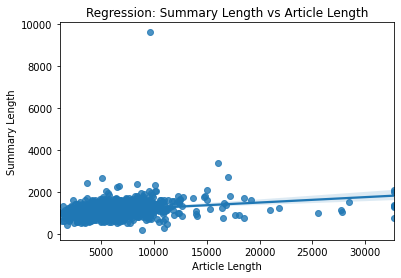

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.regplot(x='Articles', y='Summaries', data = article_length);
plt.title('Regression: Summary Length vs Article Length')
plt.xlabel('Article Length')
plt.ylabel('Summary Length')
r_squared_matrix = np.corrcoef(article_length.Articles, article_length.Summaries)**2

print('r_squared = ', round(r_squared_matrix[0][1],3))

In [18]:
word_embeddings = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_embeddings[word] = coefs
f.close()

In [19]:
def sentence_vector(sentences):
  sentence_vectors = []
  for i in sentences:
    if len(i) != 0:
      v = sum([word_embeddings.get(w, np.zeros((300,))) for w in i.split()])/(len(i.split())+0.001)
    else:
      v = np.zeros((300,))
    sentence_vectors.append(v)
  return sentence_vectors

In [20]:
def cosine_similarity_logic(sentences,sentence_vectors):
  sim_mat = np.zeros([len(sentence_vectors), len(sentence_vectors)])
  sim_mat.size
  for i in range(len(sentence_vectors)):
    for j in range(len(sentence_vectors)):
      if i != j:
        #print(i,j)
        sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,300), sentence_vectors[j].reshape(1,300))[0,0]
  return sim_mat

In [21]:
def ranking(sim_mat,sentences):
  nx_graph = nx.from_numpy_array(sim_mat)
  nx.pagerank(nx_graph, max_iter=1000000)
  scores = nx.pagerank(nx_graph)
  ranked_data= ''
  ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
  if len(ranked_sentences) >= 5:
    for i in range(5):
      ranked_data= ranked_data+ranked_sentences[i][1]
  else:
    ranked_data = ranked_sentences
  return ranked_data

In [22]:
import nltk
nltk.download('punkt')
article_summary = []
sentences = []
j = 0
start = time.time()
for s in data['clean_articles']:
  sentences = sent_tokenize(s)
  sentence_vectors = sentence_vector(sentences)
  sim_mat = cosine_similarity_logic(sentences,sentence_vectors)
  ranked_data = ranking(sim_mat,sentences)
  article_summary.append(ranked_data)
  j = j + 1
  print(j)
end = time.time()
time_taken = end - start
print("Time Taken: ", time_taken/60, " minutes")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
2

In [26]:
for i in range(len(article_summary)):
  print("Computer Generated Summary: ")
  print(i)
  print(article_summary[i])
  print("\n")

Streaming output truncated to the last 5000 lines.
Computer Generated Summary: 
0
in successfully seeking a temporary halt in the proceedings after mr. trump won house republicans last month told the court that they and the transition team currently are discussing potential options for resolution of this matter to take effect after the inauguration on jan. 20 2017. the suspension of the case house lawyers said will provide the and his future administration time to consider whether to continue prosecuting or to otherwise resolve this appeal.anticipating that the trump administration might not be inclined to health care law a vigorous fight against the house republicans given the dim view of the health care law a team of lawyers this month sought to intervene in the case on behalf of two participants in the health care program.in their request the lawyers predicted that a deal between house republicans and the new administration to dismiss or settle the case will produce devastating cons

In [23]:
!pip3 install rouge

In [24]:
from rouge import Rouge 

print("Calculating Rouge scores: ")

c,r = map(list, zip(*[[article_summary[i], data['human_summary'][i]] for i in range (len(data))]))

rouge = Rouge()

scores = rouge.get_scores(c,r,avg=True)
print(scores)

Calculating Rouge scores: 
{'rouge-1': {'f': 0.6003520144558658, 'p': 0.6124985427335171, 'r': 0.5978253674142184}, 'rouge-2': {'f': 0.4604560567091811, 'p': 0.46741890799617175, 'r': 0.45905567500561345}, 'rouge-l': {'f': 0.5567653268829487, 'p': 0.5732053133259127, 'r': 0.5477551908339859}}
